In [15]:
import pprint
import gymnasium as gym
import torch
import os
import datetime
from torch import optim
from torch.distributions.categorical import Categorical
import numpy as np
import matplotlib.pyplot as plt


In [16]:

action_type, obs_type = 'DiscreteMetaAction', 'OccupancyGrid'

env = gym.make('highway-v0', render_mode='rgb_array')
env.configure({
    'action': {'type': action_type},
    'observation': {'type': obs_type,
                    'features': ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"]
                },
    'policy_frequency': 10,
    'show_trajectories': True,
    'lanes_count': 4,
    'vehicles_density': 2,
    'vehicles_count': 50,
    'screen_height': 300,
    'screen_width': 700,
})

# pprint.pprint(env.config)

obs_space_size = env.observation_space
action_space_size = env.action_space
print(f'Action Space: {env.action_space}')
print(f'Observation Space: {env.observation_space}')


Action Space: Discrete(5)
Observation Space: Box(-inf, inf, (5, 5), float32)


c:\Python312\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


In [17]:
#Defining the network

from torch import nn

# Policy and value model
class PolicyNetwork(nn.Module):
  def __init__(self, obs_space_size, action_space_size):
    super().__init__()

    self.shared_layers = nn.Sequential(
        nn.Linear(obs_space_size, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU())

    self.policy_layers = nn.Sequential(
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, action_space_size))

    self.value_layers = nn.Sequential(
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1))

  def value(self, obs):
    z = self.shared_layers(obs)
    value = self.value_layers(z)
    return value

  def policy(self, obs):
    z = self.shared_layers(obs)
    policy_logits = self.policy_layers(z)
    return policy_logits

  def forward(self, obs):
    z = self.shared_layers(obs)
    policy_logits = self.policy_layers(z)
    value = self.value_layers(z)
    return policy_logits, value

In [18]:

class PPOAgent():
  def __init__(self,
              actor_critic,
              target_kl_div=0.01,
              max_policy_train_iters=80,
              value_train_iters=80):
    self.policy_lr = 3e-4
    self.value_lr = 0.01
    self.ac = actor_critic
    self.target_kl_div = target_kl_div
    self.max_policy_train_iters = max_policy_train_iters
    self.value_train_iters = value_train_iters
    self.ppo_clip_val = 0.2

    policy_params = list(self.ac.shared_layers.parameters()) + \
        list(self.ac.policy_layers.parameters())
    self.policy_optim = optim.Adam(policy_params, lr=self.policy_lr)

    value_params = list(self.ac.shared_layers.parameters()) + \
        list(self.ac.value_layers.parameters())
    self.value_optim = optim.Adam(value_params, lr=self.value_lr)

  def train_policy(self, obs, acts, old_log_probs, gaes):
    for _ in range(self.max_policy_train_iters):
      self.policy_optim.zero_grad()

      new_logits = self.ac.policy(obs)
      new_logits = Categorical(logits=new_logits)
      new_log_probs = new_logits.log_prob(acts)

      policy_ratio = torch.exp(new_log_probs - old_log_probs)
      clipped_ratio = policy_ratio.clamp(
          1 - self.ppo_clip_val, 1 + self.ppo_clip_val)

      clipped_loss = clipped_ratio * gaes
      full_loss = policy_ratio * gaes
      policy_loss = -torch.min(full_loss, clipped_loss).mean()

      policy_loss.backward()
      self.policy_optim.step()

      kl_div = (old_log_probs - new_log_probs).mean()
      if kl_div >= self.target_kl_div:
        break

  def train_value(self, obs, returns):
    for _ in range(self.value_train_iters):
      self.value_optim.zero_grad()

      values = self.ac.value(obs)
      value_loss = (returns - values) ** 2
      value_loss = value_loss.mean()

      value_loss.backward()
      self.value_optim.step()



In [19]:

action_type, obs_type = 'DiscreteMetaAction', 'OccupancyGrid'

def evaluate(model, state):
    logits, val = model(torch.tensor([state], dtype=torch.float32,
                                        device='cpu'))
    act_distribution = Categorical(logits=logits)
    act = act_distribution.sample()
    act_log_prob = act_distribution.log_prob(act).item()

    act, val, = act.item(), val.item()

    return act, val, act_log_prob

def rollout(model, env, max_steps=1000):

    ### Create data storage
    train_data = [[], [], [], [], []] # obs, act, reward, values, act_log_probs
    seed = 10
    state = env.reset(seed=seed, options={})
    state = env.reset(options={})
    state, _ = state
    state = np.array(state)
    ep_reward = 0
    for _ in range(max_steps):
        state = state.reshape(1, -1)
        act, val, act_log_prob = evaluate(model, state)

        next_state, reward, terminated, truncated, _ = env.step(act)
        
        print(f'reward: {reward}')
        env.render()

        for i, item in enumerate((state, act, reward, val, act_log_prob)):
            train_data[i].append(item)

        state = next_state
        ep_reward += reward
        if terminated or truncated:
            break

    train_data = [np.asarray(x) for x in train_data]

    ### Do train data filtering
    train_data[3] = compute_rewards_to_go(train_data[2], train_data[3])

    return train_data, ep_reward

def discount_rewards(rewards, gamma=0.99):

    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])

def compute_rewards_to_go(rewards, values, gamma=0.99, decay=0.97):

    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

def plot_rewards(ep_rewards):

    # Plot episode rewards
    plt.figure(figsize=(10, 5))
    plt.plot(ep_rewards, label='Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Episodes Vs Rewards')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

reward: 0.8666666666666667
reward: 0.8666666666666667
reward: 0.8417476085553975
reward: 0.8656590959987526
reward: 0.8811692741244196
reward: 0.8649618988308228
reward: 0.8503878420849341
reward: 0.8373702112256941
reward: 0.8257824700865611
reward: 0.8451107779424302
reward: 0.8326743448887947
reward: 0.8216267482204112
reward: 0.8118120402119584
reward: 0.8030914869396897
reward: 0.7953420716280468
reward: 0.7884548376196875
reward: 0.78233328529031
reward: 0.7522120717368677
reward: 0.7574612679349281
reward: 0.7482359582746644
reward: 0.7558547435721632
reward: 0.7640609139274607
reward: 0.7724201036248424
reward: 0.7435311591155244
reward: 0.7804031803715302
reward: 0.7547372304575211
reward: 0.7551269106094073
reward: 0.7587671162303445
reward: 0.0530064587921113
reward: 0.8666666666666667
reward: 0.8666666666666667
reward: 0.8666666666666667
reward: 0.8666666666666667
reward: 0.8666666666666667
reward: 0.8666666666666667
reward: 0.8666666666666667
reward: 0.8666666666666667
rew

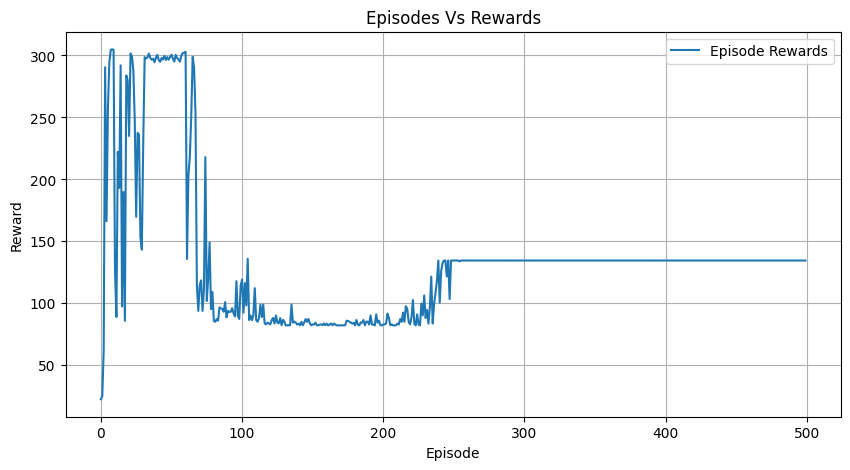

Saved actor model to: C:\Data\Northeastern\Reinforcement Learning & Sequential Decision Making\Final Project\models\actor_model.pth
Saved critic model to: C:\Data\Northeastern\Reinforcement Learning & Sequential Decision Making\Final Project\models\critic_model.pth
Saved training plot to: C:\Data\Northeastern\Reinforcement Learning & Sequential Decision Making\Final Project\models\training_progress.png


<Figure size 640x480 with 0 Axes>

In [20]:
obs_space = 847
action_space = 5
model = PolicyNetwork(obs_space, action_space)
model = model.to('cpu')

# Init Trainer
ppo = PPOAgent(
    model,
    target_kl_div = 0.02,
    max_policy_train_iters = 90,
    value_train_iters = 90)

# Training loop
ep_rewards = []
for episode_idx in range(500):
  # Perform rollout
  train_data, reward = rollout(model, env)
  ep_rewards.append(reward)

  # Shuffle
  permute_idxs = np.random.permutation(len(train_data[0]))

  # Policy data
  obs = torch.tensor(train_data[0][permute_idxs],
                     dtype=torch.float32, device='cpu')
  acts = torch.tensor(train_data[1][permute_idxs],
                      dtype=torch.int32, device='cpu')
  gaes = torch.tensor(train_data[3][permute_idxs],
                      dtype=torch.float32, device='cpu')
  act_log_probs = torch.tensor(train_data[4][permute_idxs],
                               dtype=torch.float32, device='cpu')

  # Value data
  returns = discount_rewards(train_data[2])[permute_idxs]
  returns = torch.tensor(returns, dtype=torch.float32, device='cpu')

  # Train model
  ppo.train_policy(obs, acts, act_log_probs, gaes)
  ppo.train_value(obs, returns)

  if (episode_idx + 1) % 20 == 0:
    print('=========================================')
    print('Episode {} | Avg Reward {:.1f}'.format(
        episode_idx + 1, np.mean(ep_rewards[-20:])))
    print('=========================================')

# reward plot
plot_rewards(ep_rewards)

output_folder = r'C:\Data\Northeastern\Reinforcement Learning & Sequential Decision Making\Final Project\models'
# Save the actor model
actor_model_path = os.path.join(output_folder, 'actor_model.pth')
torch.save(model.state_dict(), actor_model_path)

# Save the critic model
critic_model_path = os.path.join(output_folder, 'critic_model.pth')
torch.save(ppo.ac.state_dict(), critic_model_path)

# Save the plot as an image inside the directory
plot_path = os.path.join(output_folder, 'training_progress.png')
plt.savefig(plot_path)

print("Saved actor model to:", actor_model_path)
print("Saved critic model to:", critic_model_path)
print("Saved training plot to:", plot_path)
# env.close()
# show_videos()

In [21]:
def load_models(actor_model_path, critic_model_path, obs_space, action_space):
    # Load saved actor model
    actor_model = PolicyNetwork(obs_space, action_space)
    actor_model.load_state_dict(torch.load(actor_model_path))
    actor_model.eval()

    # Load saved critic model
    critic_model = PolicyNetwork(obs_space, action_space)
    critic_model.load_state_dict(torch.load(critic_model_path))
    critic_model.eval()

    return actor_model, critic_model

obs_space = 847
action_space = 5
actor_model_path = r'C:\Data\Northeastern\Reinforcement Learning & Sequential Decision Making\Final Project\actor_model.pth'
critic_model_path = r'C:\Data\Northeastern\Reinforcement Learning & Sequential Decision Making\Final Project\critic_model.pth'

actor_model, critic_model = load_models(actor_model_path, critic_model_path, obs_space, action_space)


In [22]:
rewards = []
avg_rewards = []
for i in range(15):
    terminated = False
    truncated = False
    env.np_random
    state, _ = env.reset()
    state = state.squeeze()
    while not terminated or truncated:
        with torch.no_grad():
            states = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            policy_logits = actor_model.policy(states) 
            action_distribution = Categorical(logits=policy_logits)
            action = action_distribution.sample().item()

        state, reward, terminated, truncated, _ = env.step(action)

        rewards.append(reward)
        env.render()

    avg_reward = np.mean(rewards)
    avg_rewards.append(avg_reward)
    print(f'Episode: {i+1} Avg Reward: {avg_reward}')

print(f'Avg Reward for {i+1} Iteration(s): {np.mean(avg_rewards)}')

env.close()


Episode: 1 Avg Reward: 0.7928730810090929
Episode: 2 Avg Reward: 0.7919552202299612
Episode: 3 Avg Reward: 0.7907320881519762
Episode: 4 Avg Reward: 0.7885703223581906
Episode: 5 Avg Reward: 0.7898884495640601
Episode: 6 Avg Reward: 0.7899052520319896
Episode: 7 Avg Reward: 0.7895914941649178
Episode: 8 Avg Reward: 0.7907372301674365
Episode: 9 Avg Reward: 0.7917404352369114
Episode: 10 Avg Reward: 0.7909800220358586
Episode: 11 Avg Reward: 0.7905218228961741
Episode: 12 Avg Reward: 0.7900848845591805
Episode: 13 Avg Reward: 0.789859268812285
Episode: 14 Avg Reward: 0.7897554610639987
Episode: 15 Avg Reward: 0.7896615397679304
Avg Reward for 15 Iteration(s): 0.7904571048033308
